In [1]:
from google.colab import drive
import os
import glob
import pandas as pd

drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/data-science-veiculos-poluicao'
os.chdir(folder_path)

print(os.listdir())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['senatran', 'iema', 'senastran_tipo.ipynb', 'MSysObjects.csv', '2025-07-20 18-33-52.mkv', 'iema-agg', 'senatran-agg', 'cidades_lookup.csv', 'cidades.ipynb', 'iema.ipynb', 'TCC ESALQ USP DATA SCIENCE.gdoc', 'analise_1.ipynb']


In [2]:
csv_files_senatran = glob.glob('senatran-agg/marca_modelo/*.csv')

dfs_list_senatran = []

for file in csv_files_senatran:
    df = pd.read_csv(file)
    dfs_list_senatran.append(df)

marca_modelo_senatran = pd.concat(dfs_list_senatran, ignore_index=True)
marca_modelo_senatran.head()

,cidade,id,UF,category,qtd,ano,mes
0,AMERICANA,SP01,SAO PAULO,BUS,52,2015,2
1,AMERICANA,SP01,SAO PAULO,CLASSIC,4498,2015,2
2,AMERICANA,SP01,SAO PAULO,HATCHBACK,42446,2015,2
3,AMERICANA,SP01,SAO PAULO,MOTORCYCLE,16851,2015,2
4,AMERICANA,SP01,SAO PAULO,OTHER,70843,2015,2


In [3]:
min_ano = 2015
min_mes = 1
max_ano = 2019
max_mes = 12

start_date = f'{min_ano}-{min_mes:02d}-01'
end_date = f'{max_ano}-{max_mes:02d}-01'

date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

full_time_range = pd.DataFrame({
    'ano': date_range.year,
    'mes': date_range.month
})

display(full_time_range.head())
display(full_time_range.tail())

,ano,mes
0,2015,1
1,2015,2
2,2015,3
3,2015,4
4,2015,5


,ano,mes
55,2019,8
56,2019,9
57,2019,10
58,2019,11
59,2019,12


In [4]:
print(str(min_ano) + "-" + str(min_mes))

print(str(max_ano) + "-" + str(max_mes))

2015-1
2019-12


In [5]:
unique_locations = marca_modelo_senatran[['cidade', 'id', 'UF', 'category']].drop_duplicates()
complete_index = pd.merge(unique_locations.assign(key=1), full_time_range.assign(key=1), on='key').drop('key', axis=1)
display(complete_index.head())

,cidade,id,UF,category,ano,mes
0,AMERICANA,SP01,SAO PAULO,BUS,2015,1
1,AMERICANA,SP01,SAO PAULO,BUS,2015,2
2,AMERICANA,SP01,SAO PAULO,BUS,2015,3
3,AMERICANA,SP01,SAO PAULO,BUS,2015,4
4,AMERICANA,SP01,SAO PAULO,BUS,2015,5


In [6]:
marca_modelo_senatran_reindexed = pd.merge(complete_index, marca_modelo_senatran, on=['cidade', 'id', 'UF', 'category', 'ano', 'mes'], how='left')
display(marca_modelo_senatran_reindexed.head())

,cidade,id,UF,category,ano,mes,qtd
0,AMERICANA,SP01,SAO PAULO,BUS,2015,1,51.0
1,AMERICANA,SP01,SAO PAULO,BUS,2015,2,52.0
2,AMERICANA,SP01,SAO PAULO,BUS,2015,3,51.0
3,AMERICANA,SP01,SAO PAULO,BUS,2015,4,NaN
4,AMERICANA,SP01,SAO PAULO,BUS,2015,5,54.0


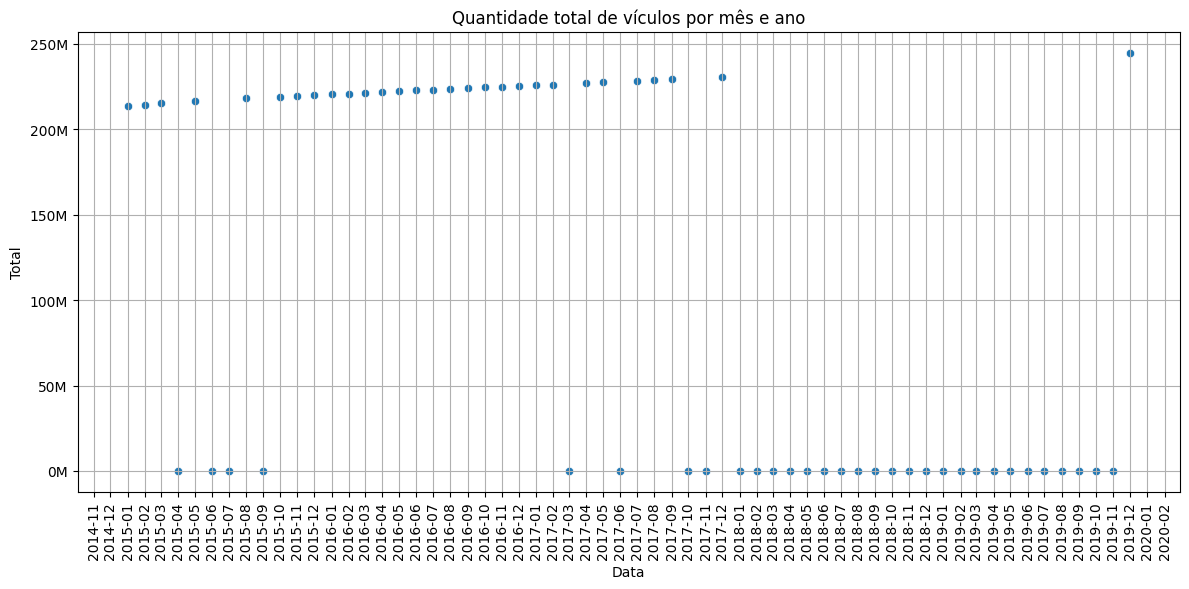

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# Aggregate the data by year and month
monthly_total_qtd = marca_modelo_senatran_reindexed.groupby(['ano', 'mes'])['qtd'].sum().reset_index()

# Convert 'ano' and 'mes' to a datetime format for plotting
monthly_total_qtd['date'] = pd.to_datetime(monthly_total_qtd['ano'].astype(str) + '-' + monthly_total_qtd['mes'].astype(str) + '-01')

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=monthly_total_qtd, x='date', y='qtd')
plt.title('Quantidade total de vículos por mês e ano')
plt.xlabel('Data')
plt.ylabel('Total')

# Format x-axis to show all months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

# Format y-axis to not use scientific notation and show in millions
def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'

ax.yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))

# Add grid
plt.grid(True)

plt.tight_layout()
plt.show()

Foi observado que alguns valores como 2015-09 são outliers, em que chegam a desaparecer cerda de 15 milhões de veículos, os outliers são removidos para que a interpolação seja mais confiável

In [8]:
marca_modelo_senatran_reindexed.loc[(marca_modelo_senatran_reindexed['ano'] == 2015) & (marca_modelo_senatran_reindexed['mes'] == 9), 'qtd'] = None
marca_modelo_senatran_reindexed.loc[(marca_modelo_senatran_reindexed['ano'] == 2017) & (marca_modelo_senatran_reindexed['mes'] == 3), 'qtd'] = None
marca_modelo_senatran_reindexed.loc[(marca_modelo_senatran_reindexed['ano'] == 2017) & (marca_modelo_senatran_reindexed['mes'] == 10), 'qtd'] = None
marca_modelo_senatran_reindexed.loc[(marca_modelo_senatran_reindexed['ano'] == 2017) & (marca_modelo_senatran_reindexed['mes'] == 11), 'qtd'] = None

display(marca_modelo_senatran_reindexed[(marca_modelo_senatran_reindexed['ano'] == 2015) & (marca_modelo_senatran_reindexed['mes'] == 9)].head())

,cidade,id,UF,category,ano,mes,qtd
8,AMERICANA,SP01,SAO PAULO,BUS,2015,9,NaN
68,AMERICANA,SP01,SAO PAULO,CLASSIC,2015,9,NaN
128,AMERICANA,SP01,SAO PAULO,HATCHBACK,2015,9,NaN
188,AMERICANA,SP01,SAO PAULO,MOTORCYCLE,2015,9,NaN
248,AMERICANA,SP01,SAO PAULO,OTHER,2015,9,NaN


In [9]:
marca_modelo_senatran_interpolated = marca_modelo_senatran_reindexed.copy()

# Interpolate missing values
marca_modelo_senatran_interpolated['qtd'] = marca_modelo_senatran_interpolated.groupby(['cidade', 'id', 'UF', 'category'])['qtd'].transform(lambda x: x.interpolate(method='linear'))

display(marca_modelo_senatran_interpolated.head())

,cidade,id,UF,category,ano,mes,qtd
0,AMERICANA,SP01,SAO PAULO,BUS,2015,1,51.0
1,AMERICANA,SP01,SAO PAULO,BUS,2015,2,52.0
2,AMERICANA,SP01,SAO PAULO,BUS,2015,3,51.0
3,AMERICANA,SP01,SAO PAULO,BUS,2015,4,52.5
4,AMERICANA,SP01,SAO PAULO,BUS,2015,5,54.0


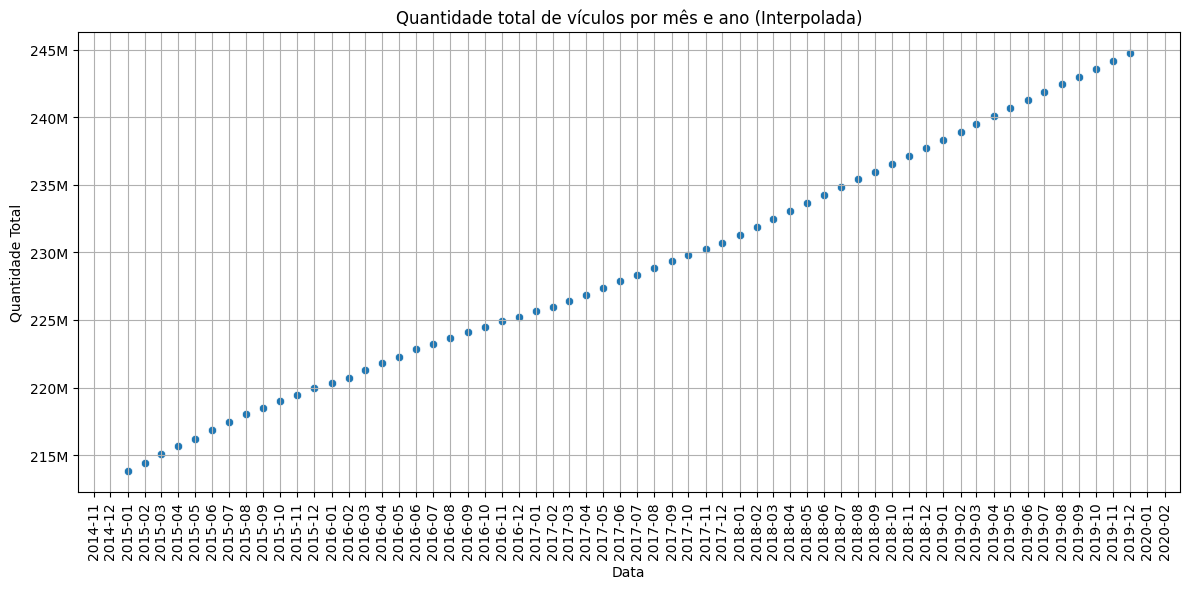

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# Aggregate the data by year and month
monthly_total_qtd_interpolated = marca_modelo_senatran_interpolated.groupby(['ano', 'mes'])['qtd'].sum().reset_index()

# Convert 'ano' and 'mes' to a datetime format for plotting
monthly_total_qtd_interpolated['date'] = pd.to_datetime(monthly_total_qtd_interpolated['ano'].astype(str) + '-' + monthly_total_qtd_interpolated['mes'].astype(str) + '-01')

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=monthly_total_qtd_interpolated, x='date', y='qtd')
plt.title('Quantidade total de vículos por mês e ano (Interpolada)')
plt.xlabel('Data')
plt.ylabel('Quantidade Total')

# Format x-axis to show all months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

# Format y-axis to not use scientific notation and show in millions
def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'

ax.yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))

# Add grid
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Filter for SUV category
df_suv = marca_modelo_senatran_interpolated[marca_modelo_senatran_interpolated['category'] == 'SUV']

# Filter for other categories
df_other = marca_modelo_senatran_interpolated[marca_modelo_senatran_interpolated['category'] != 'SUV']

# Aggregate total qtd for SUV by year and month
monthly_total_qtd_suv = df_suv.groupby(['ano', 'mes'])['qtd'].sum().reset_index()
monthly_total_qtd_suv['category'] = 'SUV'


# Aggregate total qtd for other categories by year and month
monthly_total_qtd_other = df_other.groupby(['ano', 'mes'])['qtd'].sum().reset_index()
monthly_total_qtd_other['category'] = 'Other Categories'

# Combine the dataframes for plotting
combined_monthly_qtd = pd.concat([monthly_total_qtd_suv, monthly_total_qtd_other])

# Convert 'ano' and 'mes' to a datetime format for plotting
combined_monthly_qtd['date'] = pd.to_datetime(combined_monthly_qtd['ano'].astype(str) + '-' + combined_monthly_qtd['mes'].astype(str) + '-01')

display(combined_monthly_qtd.head())

,ano,mes,qtd,category,date
0,2015,1,2463044.0,SUV,2015-01-01
1,2015,2,2480363.0,SUV,2015-02-01
2,2015,3,2500654.0,SUV,2015-03-01
3,2015,4,2516955.5,SUV,2015-04-01
4,2015,5,2533257.0,SUV,2015-05-01


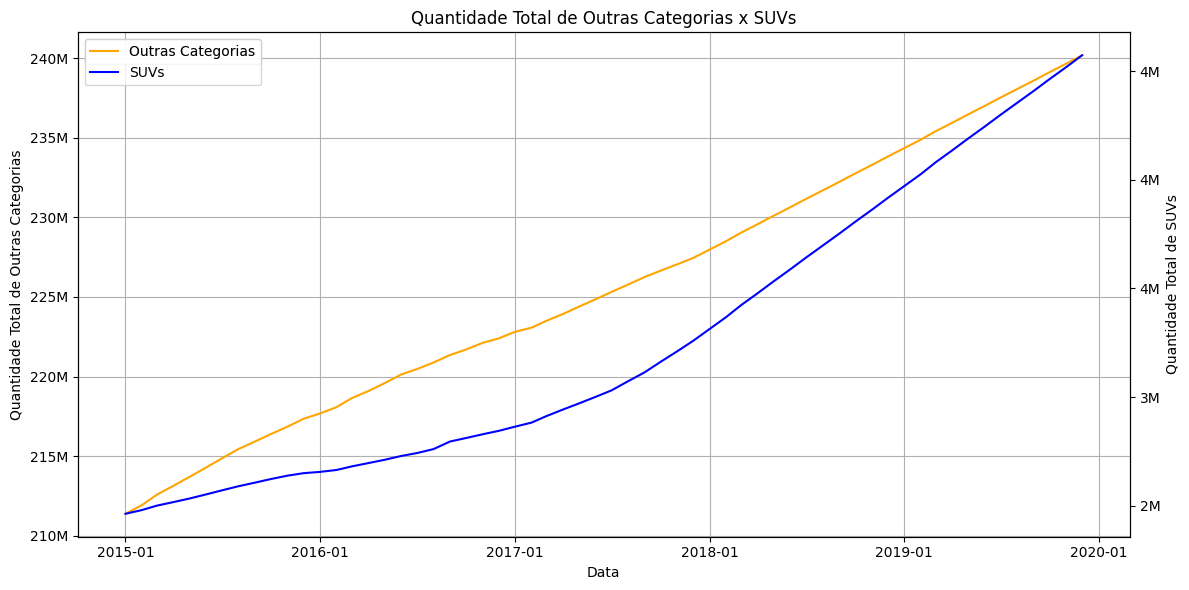

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# Separate the data for SUV and Other Categories
df_suv_plot = combined_monthly_qtd[combined_monthly_qtd['category'] == 'SUV']
df_other_plot = combined_monthly_qtd[combined_monthly_qtd['category'] == 'Other Categories']

# Create the plot with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Other Categories on the primary y-axis
sns.lineplot(data=df_other_plot, x='date', y='qtd', ax=ax1, label='Outras Categorias', color='orange')
ax1.set_xlabel('Data')
ax1.set_ylabel('Quantidade Total de Outras Categorias')
ax1.set_title('Quantidade Total de Outras Categorias x SUVs')

# Format primary y-axis to not use scientific notation and show in millions
def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))


# Create a secondary y-axis for SUV
ax2 = ax1.twinx()
sns.lineplot(data=df_suv_plot, x='date', y='qtd', ax=ax2, label='SUVs322', color='blue')
ax2.set_ylabel('Quantidade Total de SUVs')

# Format secondary y-axis to not use scientific notation and show in millions
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))

# Format x-axis to show all months
#ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

# Add grids
ax1.grid(True)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')


plt.tight_layout()
plt.show()

In [13]:
# Calculate the derivative (difference between consecutive months) for SUV
monthly_total_qtd_suv['qtd_derivative'] = monthly_total_qtd_suv['qtd'].diff()

# Calculate the derivative for Other Categories
monthly_total_qtd_other['qtd_derivative'] = monthly_total_qtd_other['qtd'].diff()

# Combine the dataframes for plotting, including the 'date' column
combined_monthly_qtd_derivative = pd.concat([monthly_total_qtd_suv, monthly_total_qtd_other])

# Ensure the 'date' column is in the combined dataframe
combined_monthly_qtd_derivative['date'] = pd.to_datetime(combined_monthly_qtd_derivative['ano'].astype(str) + '-' + combined_monthly_qtd_derivative['mes'].astype(str) + '-01')

display(combined_monthly_qtd_derivative.head())

,ano,mes,qtd,category,qtd_derivative,date
0,2015,1,2463044.0,SUV,NaN,2015-01-01
1,2015,2,2480363.0,SUV,17319.0,2015-02-01
2,2015,3,2500654.0,SUV,20291.0,2015-03-01
3,2015,4,2516955.5,SUV,16301.5,2015-04-01
4,2015,5,2533257.0,SUV,16301.5,2015-05-01


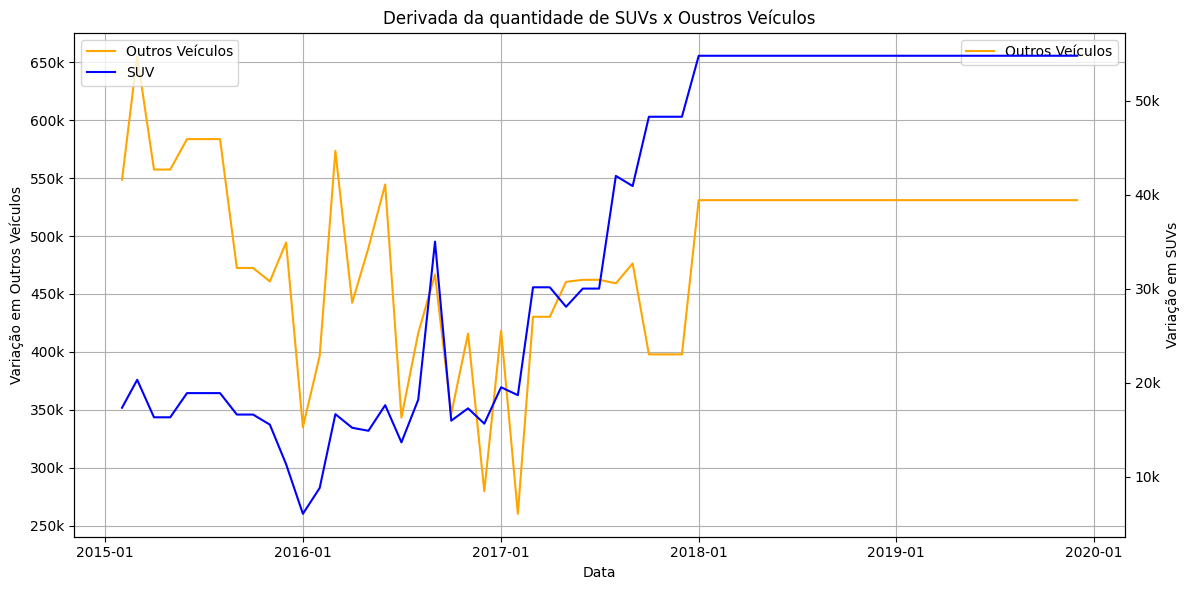

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# Separate the data for SUV and Other Categories derivatives
df_suv_derivative_plot = combined_monthly_qtd_derivative[combined_monthly_qtd_derivative['category'] == 'SUV']
df_other_derivative_plot = combined_monthly_qtd_derivative[combined_monthly_qtd_derivative['category'] == 'Other Categories']

# Create the plot with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Other Categories derivatives on the primary y-axis
sns.lineplot(data=df_other_derivative_plot, x='date', y='qtd_derivative', ax=ax1, label='Outros Veículos', color='orange')
ax1.set_xlabel('Data')
ax1.set_ylabel('Variação em Outros Veículos')
ax1.set_title('Derivada da quantidade de SUVs x Oustros Veículos')

# Format primary y-axis to not use scientific notation and show in millions
def millions_formatter(x, pos):
    return f'{x / 1e3:.0f}k'
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))


# Create a secondary y-axis for SUV derivatives
ax2 = ax1.twinx()
sns.lineplot(data=df_suv_derivative_plot, x='date', y='qtd_derivative', ax=ax2, label='SUV', color='blue')
ax2.set_ylabel('Variação em SUVs')

# Format secondary y-axis to not use scientific notation and show in millions
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))


# Format x-axis to show all months
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

# Add grids
ax1.grid(True)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [26]:
# Define the output folder path
output_folder_path = '/content/drive/MyDrive/data-science-veiculos-poluicao/senatran-agg/marca_modelo_interpolado'

# Create the output folder if it doesn't exist
os.makedirs(output_folder_path, exist_ok=True)

# Define the output file path
output_file_path = os.path.join(output_folder_path, 'marca_modelo_senatran_interpolated.csv')

# Save the DataFrame to a CSV file
marca_modelo_senatran_interpolated.to_csv(output_file_path, index=False)

print(f'DataFrame saved to: {output_file_path}')

DataFrame saved to: /content/drive/MyDrive/data-science-veiculos-poluicao/senatran-agg/marca_modelo_interpolado/marca_modelo_senatran_interpolated.csv
